# Back Propagation Assignment 

In [1]:
%config IPCompleter.greedy=True
from random import random
from random import seed
import numpy as np
import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt 

### Class Layer - A layer in our Neural Network

In [2]:
class Layer:
    """
    Represents a layer (hidden or output) in our Neural Network.
    """

    def __init__(self, n_input, n_neurons, activation_function=None, weights=None, bias=None):
        """
        Constructor to initialize the layer.
        :param n_input: Input size (coming from the input layer or a previous hidden layer)
        :param n_neurons: Number of neurons in this layer.
        :param activation_function: Activation function to use (if any).
        :param weights: The layer's weights of dimension [Input size(n_input), Nodes in this layer(n_neurons)]
        :param bias: The layer's bias.
        :var outputs: Stores the output(activations) of this layer during feed_forward.
        :var error: Stores the error values of this layer during back_propagate_error.
        :var delta: Stores the delta values of this layer during back_propagate_error.
        """
        self.weights = weights if weights is not None else np.random.rand(n_input, n_neurons)
        self.activation_function = activation_function
        self.bias = bias if bias is not None else np.random.rand(n_neurons)
        self.outputs = None
        self.error = None
        self.delta = None

    def activate(self, x):
        """
        Calculates the dot product of this layer.
        :param x: The input.
        :return: The result.
        """
        r = np.dot(x, self.weights) + self.bias
        self.outputs = self._apply_activation(r)
        return self.outputs

    def _apply_activation(self, x):
        """
        Applies the chosen activation function (if any).
        :param x: The normal value.
        :return: The "activated" value.
        """
        # In case no activation function was chosen
        if self.activation_function is None:
            return x
        # tanh
        if self.activation_function == 'tanh':
            return np.tanh(x)
        # sigmoid
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        #relu
        if self.activation_function == 'relu':
            return np.maximum(0,x)
        # linear
        if self.activation_function == 'linear':
            return x

    def apply_activation_derivative(self, x):
        """
        Applies the derivative of the activation function (if any).
        :param x: The normal value.
        :return: The "derived" value.
        """
        # We use 'x' directly here because its already activated and stored in outputs.
        if self.activation_function is None:
            return x
        if self.activation_function == 'tanh':
            return 1 - x ** 2
        if self.activation_function == 'sigmoid':
            return x * (1 - x)
        if self.activation_function == 'relu':
            return (x > 0).astype(int)
        if self.activation_function == 'linear':
            return 1


### Class NeuralNetwork - Defines our Model

In [19]:
class NeuralNetwork:
    """
    Represents the Neural Network for modelling the problem
    """
    
    def __init__(self, n_inputs, n_hidden, n_outputs, activation_functions=None):
        """
        Constructor to initialize the network.
        :param n_inputs: Number of Input Nodes
        :param n_hidden: An Array of hidden layers. Length of array defines the number of hidden layers (minimum 1) 
                         and its value defines the number of nodes in that layer.
        :param n_outputs: Number of Output Nodes (Outpute Layer)
        :param activation_functions: An Array of activation functions to be applied on each layer in the network.
        """
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        if activation_functions is not None:
            self.activation_functions = activation_functions
        else:
            self.activation_functions = [None] * (len(n_hidden)+1)
        self.network = self.initialize_network()
        
    def initialize_network(self):
        '''
        Initialize a new neural network for training.
        '''
        network = list()
        hidden_layer = Layer(self.n_inputs, self.n_hidden[0], self.activation_functions[0])
        network.append(hidden_layer)
        for i in range(1,len(self.n_hidden)):
            hidden_layer = Layer(self.n_hidden[i-1], self.n_hidden[i], self.activation_functions[i])
            network.append(hidden_layer)
        output_layer = Layer(self.n_hidden[-1], self.n_outputs, self.activation_functions[-1])
        network.append(output_layer)
        
        print('-'*100)
        print("Model Summary :")
        for i,layer in enumerate(network):
            print("Layer {} Weights Dimension = {} Bias = {} Activation Function = {}".format(i, layer.weights.shape, layer.bias.shape, layer.activation_function))
        print('-'*100)
        
        return network
    
    def feed_forward(self, X):
        """
        Feed forward the input through the layers.
        :param X: Input values.
        """
        for layer in self.network:
            X = layer.activate(X)
        return X
    
    def back_propagate_error(self, Y, output):
        """
        Back Propagate errors and store (error and delta) in the respective layers.
        :param Y: Target values 
        :param output: Output from the feed_forward network
        """
        for i in reversed(range(len(self.network))):
            layer = self.network[i]
            if layer == self.network[-1]:
                # Calculate error and delta for output layer
                layer.error = Y - output
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:
                # Calculate error and delta for hidden layer
                next_layer = self.network[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.outputs)
    
    def update_weights(self, X, l_rate):
        """
        Update the weights of the layer given the learning rate
        :param X: Input values
        :param l_rate: Learning Rate
        """
        for i in range(len(self.network)):
            layer = self.network[i]
            X = np.atleast_2d(X if i == 0 else self.network[i - 1].outputs)
            layer.weights += layer.delta * X.T * l_rate
            layer.bias += layer.delta * l_rate
            
    def train(self, X, Y, l_rate=0.001, epochs=100):
        """
        Trains the network for fixed number of epochs using Stochastic Gradient Descent.
        :param X: Input values
        :param Y: Target values
        :param l_rate: Learning Rate
        :param epochs: Number of epochs to train
        :return: Calculated MSE errors.
        """
        print("Training on {} input values with Learning Rate - {} :".format(X.shape[0], l_rate))
        MSEs = list()
        for i in range(epochs):
            # Forward Propagate to calculate output values
            for j in range(len(X)):
                output = self.feed_forward(X[j])
                self.back_propagate_error(Y[j], output)
                self.update_weights(X[j], l_rate)
            mse = np.mean(np.square(Y - self.feed_forward(X)))
            MSEs.append(mse)
            if i == 0:
                print('Epoch: #%s/%s, MSE: %f' % (i+1, epochs, float(mse)))
            elif (i+1) % 100 == 0:
                print('Epoch: #%s/%s, MSE: %f' % (i+1, epochs, float(mse)))
        return MSEs
    
    def predict(self, X):
        """
        Predicts a class (or classes).
        :param X: Input values.
        :return: Predictions.
        """
        output = self.feed_forward(X)
        # One row
        if output.ndim == 1:
            return (output == output.max(axis=0, keepdims=1)).astype(int)
        # Multiple rows
        return (output == output.max(axis=1, keepdims=1)).astype(int)
    
    @staticmethod
    def accuracy(y_pred, y_true):
        """
        Calculates the accuracy between the predicted values and true values.
        :param y_pred: Predicted values.
        :param y_true: True values.
        :return: Calculated Accuracy.
        """
        return (y_pred == y_true).mean()

### Modelling the Sine Curve (with sigmoid and tanh activation functions)

#### Structure of the Model :
- Input : 1 value.
- Hidden Layer : 10 Nodes & Activation Function : Sigmoid
- Output Layer : 1 Node & Activavtion Function : Tanh

#### Training Parameters :
- Learning Rate : 0.3
- Epochs : 1000

----------------------------------------------------------------------------------------------------
Model Summary :
Layer 0 Weights Dimension = (1, 10) Bias = (10,) Activation Function = sigmoid
Layer 1 Weights Dimension = (10, 1) Bias = (1,) Activation Function = tanh
----------------------------------------------------------------------------------------------------
Dimensions of X :  (1000, 1)
Dimensions of Y :  (1000, 1)
Training on 1000 input values with Learning Rate - 0.3 :
Epoch: #1/1000, MSE: 0.107750
Epoch: #100/1000, MSE: 0.002120
Epoch: #200/1000, MSE: 0.001045
Epoch: #300/1000, MSE: 0.000846
Epoch: #400/1000, MSE: 0.000610
Epoch: #500/1000, MSE: 0.000467
Epoch: #600/1000, MSE: 0.000408
Epoch: #700/1000, MSE: 0.000380
Epoch: #800/1000, MSE: 0.000361
Epoch: #900/1000, MSE: 0.000346
Epoch: #1000/1000, MSE: 0.000332


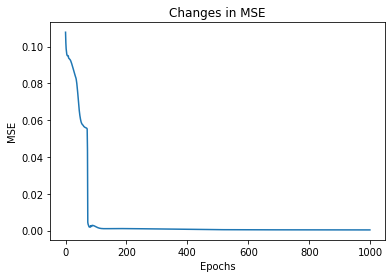

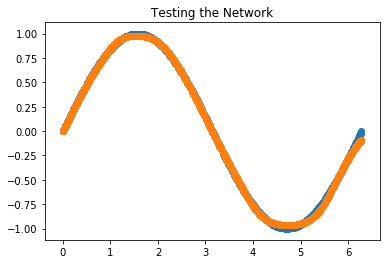

In [12]:
if __name__ == '__main__':  
    # Make results reproducible
    np.random.seed(100)
    
    #Initialize the network.
    network = NeuralNetwork(1, [10], 1, ['sigmoid','tanh'])
    
    # Generate random values for X and Y
    X = 2*np.pi*np.random.rand(1000).reshape(1, -1)
    X = X.T
    y = np.sin(X)
    print("Dimensions of X : ", X.shape)
    print("Dimensions of Y : ", y.shape)
    
    # Train the network
    errors = network.train(X, y, l_rate = 0.3, epochs=1000)
    plt.plot(errors)
    plt.title('Changes in MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()
    
    # Test the network
    y_pred = network.feed_forward(X)
    plt.scatter(X.flatten(), y.flatten())
    plt.scatter(X.flatten(), y_pred.flatten())
    plt.title("Testing the Network")
    plt.show()

### Modelling the Sine Curve (with relu and tanh activation functions)

#### Structure of the Model :
- Input : 1 value. 
- Hidden Layer : 10 Nodes & Activation Function : Relu
- Output Layer : 1 Node & Activavtion Function : Tanh

#### Training Parameters :
- Learning Rate : 0.1
- Epochs : 500

----------------------------------------------------------------------------------------------------
Model Summary :
Layer 0 Weights Dimension = (1, 10) Bias = (10,) Activation Function = relu
Layer 1 Weights Dimension = (10, 1) Bias = (1,) Activation Function = tanh
----------------------------------------------------------------------------------------------------
Dimensions of X :  (1000, 1)
Dimensions of Y :  (1000, 1)
Training on 1000 input values with Learning Rate - 0.1 :
Epoch: #1/500, MSE: 0.120171
Epoch: #100/500, MSE: 0.001595
Epoch: #200/500, MSE: 0.001579
Epoch: #300/500, MSE: 0.001571
Epoch: #400/500, MSE: 0.001561
Epoch: #500/500, MSE: 0.001555


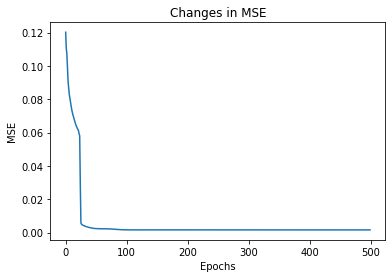

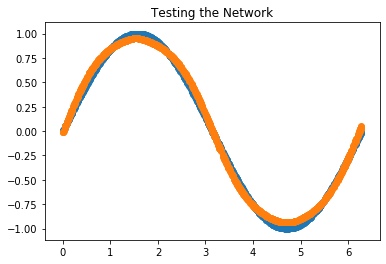

In [13]:
if __name__ == '__main__':  
    # Make results reproducible
    np.random.seed(100)
    
    #Initialize the network.
    network = NeuralNetwork(1, [10], 1, ['relu','tanh'])
    
    # Generate random values for X and Y
    X = 2*np.pi*np.random.rand(1000).reshape(1, -1)
    X = X.T
    y = np.sin(X)
    print("Dimensions of X : ", X.shape)
    print("Dimensions of Y : ", y.shape)
    
    # Train the network
    errors = network.train(X, y, l_rate = 0.1, epochs=500)
    plt.plot(errors)
    plt.title('Changes in MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()
    
    # Test the network
    y_pred = network.feed_forward(X)
    plt.scatter(X.flatten(), y.flatten())
    plt.scatter(X.flatten(), y_pred.flatten())
    plt.title("Testing the Network")
    plt.show()

### Utility Function to Load Iris Dataset

In [14]:
def load_iris():
    dataset = pd.read_csv('iris.csv')
    print("Loaded Dataset : (Total Rows in Dataset : {})".format(dataset.shape[0]))
    display(dataset)    
    dataset = pd.get_dummies(dataset, columns=['species']) # One Hot Encoding
    values = list(dataset.columns.values)

    X = dataset[values[0:-3]]
    print("Input Values (X) are of the form :")
    display(X)
    X = np.array(X, dtype='float32')

    print("Target Values (Y) are of the form")
    y = dataset[values[-3:]]
    display(y)
    y = np.array(y, dtype='int')

    # Shuffle Data
    indices = np.random.choice(len(X), len(X), replace=False)
    X_values = X[indices]
    y_values = y[indices]

    # Create Training and Testing data
    test_size = 10
    X_train = X_values[:-test_size]
    X_test = X_values[-test_size:]
    y_train = y_values[:-test_size]
    y_test = y_values[-test_size:]

    return X_train, X_test, y_train, y_test

### Model for the Iris Dataset

#### Structure of the Model :
- Input : 4 values
- Hidden Layer : 8 Nodes & Activation Function : Sigmoid
- Output Layer : 3 Nodes & Activavtion Function : Sigmoid

#### Training Parameters :
- Learning Rate : 0.001
- Epochs : 3000

----------------------------------------------------------------------------------------------------
Model Summary :
Layer 0 Weights Dimension = (4, 8) Bias = (8,) Activation Function = sigmoid
Layer 1 Weights Dimension = (8, 3) Bias = (3,) Activation Function = sigmoid
----------------------------------------------------------------------------------------------------
Loaded Dataset : (Total Rows in Dataset : 150)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Input Values (X) are of the form :


,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Target Values (Y) are of the form


,species_setosa,species_versicolor,species_virginica
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
145,0,0,1
146,0,0,1
147,0,0,1
148,0,0,1


Training on 140 input values with Learning Rate - 0.001 :
Epoch: #1/3000, MSE: 0.650852
Epoch: #100/3000, MSE: 0.494443
Epoch: #200/3000, MSE: 0.223892
Epoch: #300/3000, MSE: 0.219442
Epoch: #400/3000, MSE: 0.211404
Epoch: #500/3000, MSE: 0.198175
Epoch: #600/3000, MSE: 0.182154
Epoch: #700/3000, MSE: 0.167669
Epoch: #800/3000, MSE: 0.156295
Epoch: #900/3000, MSE: 0.147761
Epoch: #1000/3000, MSE: 0.141379
Epoch: #1100/3000, MSE: 0.136541
Epoch: #1200/3000, MSE: 0.132796
Epoch: #1300/3000, MSE: 0.129829
Epoch: #1400/3000, MSE: 0.127418
Epoch: #1500/3000, MSE: 0.125413
Epoch: #1600/3000, MSE: 0.123714
Epoch: #1700/3000, MSE: 0.122241
Epoch: #1800/3000, MSE: 0.120920
Epoch: #1900/3000, MSE: 0.119685
Epoch: #2000/3000, MSE: 0.118481
Epoch: #2100/3000, MSE: 0.117253
Epoch: #2200/3000, MSE: 0.115947
Epoch: #2300/3000, MSE: 0.114504
Epoch: #2400/3000, MSE: 0.112858
Epoch: #2500/3000, MSE: 0.110936
Epoch: #2600/3000, MSE: 0.108662
Epoch: #2700/3000, MSE: 0.105966
Epoch: #2800/3000, MSE: 0.1028

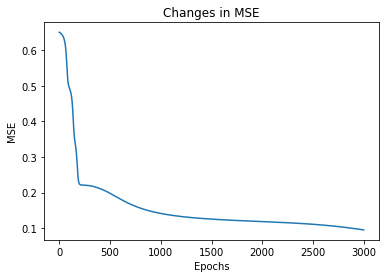

Testing the Network :
True Values : [1 0 0] 	 Predicted Values : [0.89438876 0.15586906 0.04395918] -> [1 0 0]
True Values : [0 0 1] 	 Predicted Values : [0.05998615 0.44036422 0.53639375] -> [0 0 1]
True Values : [0 0 1] 	 Predicted Values : [0.05732761 0.41800804 0.55593179] -> [0 0 1]
True Values : [0 0 1] 	 Predicted Values : [0.05828245 0.42619056 0.54880696] -> [0 0 1]
True Values : [1 0 0] 	 Predicted Values : [0.89087287 0.15615242 0.04544305] -> [1 0 0]
True Values : [1 0 0] 	 Predicted Values : [0.89460162 0.15467411 0.04397622] -> [1 0 0]
True Values : [1 0 0] 	 Predicted Values : [0.89092762 0.15809288 0.04501147] -> [1 0 0]
True Values : [0 1 0] 	 Predicted Values : [0.08639686 0.5728882  0.40002092] -> [0 1 0]
True Values : [0 1 0] 	 Predicted Values : [0.0733605  0.51714264 0.45973426] -> [0 1 0]
True Values : [0 0 1] 	 Predicted Values : [0.06045948 0.44322926 0.53347899] -> [0 0 1]

Accuracy: 100.00%


In [20]:
if __name__ == '__main__':    
    # Make results reproducible
    np.random.seed(100)
    
    # Initialize the network
    network = NeuralNetwork(4, [8], 3, ['sigmoid','sigmoid'])
    
    # Load the Dataset
    X_train, X_test, y_train, y_test = load_iris()
    
    # Train the Network
    errors = network.train(X_train, y_train, l_rate = 0.001, epochs=3000)
    plt.plot(errors)
    plt.title('Changes in MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()
    
    print("Testing the Network :")
    output = network.feed_forward(X_test)
    y_pred = network.predict(X_test)
    for i in range(len(X_test)):
        print("True Values : {} \t Predicted Values : {} -> {}".format(y_test[i], output[i], y_pred[i]))
        
    print('\nAccuracy: %.2f%%' % (network.accuracy(y_pred, y_test) * 100))

### We can also Define Models with Multiple Layers 

#### For Example : Consider following Model :
##### Structure of the Model :
- Input : 3 values
- Hidden Layer - 1 : 4 Nodes & Activation Function : Tanh
- Hidden Layer - 2 : 5 Nodes & Activation Function : Relu
- Hidden Layer - 3 : 3 Nodes & Activation Function : Sigmoid
- Output Layer : 2 Nodes & Activavtion Function : Linear

In [16]:
network = NeuralNetwork(3, [4,5,3], 2, ['tanh','relu','sigmoid','linear'])

----------------------------------------------------------------------------------------------------
Model Summary :
Layer 0 Weights Dimension = (3, 4) Bias = (4,) Activation Function = tanh
Layer 1 Weights Dimension = (4, 5) Bias = (5,) Activation Function = relu
Layer 2 Weights Dimension = (5, 3) Bias = (3,) Activation Function = sigmoid
Layer 3 Weights Dimension = (3, 2) Bias = (2,) Activation Function = linear
----------------------------------------------------------------------------------------------------
